### План решения.

1. Обучаемся и валидируемся на семи фолдах. 
2. Сперва получаем результаты используя базовую сеть.
3. Затем берем из этой сети эмбеддинги данных и учим бустер.
4. Затем из полученных предсказаний выбираем крайние и даем им псевдо метки. Расширяем трейн.
5. Повторяем обучение в сети и бустинге.
6. Из всех ранее полученных предсказаний выбираем то усреднение которое дает лучший ROCAUC.
7. Всё выше перечисленное выполняется для каждого фолда отдельно и затем собирается в конечный результат.

### 0. Imports and requirements

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import sys
import pickle
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras import Model


from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import lightgbm as lgb 
from bayes_opt import BayesianOptimization
from itertools import combinations

import tqdm
import time
import warnings
warnings.filterwarnings("ignore")



os.environ["CUDA_VISIBLE_DEVICES"] = "0"
pd.set_option('display.max_columns', None)

# добавим родительскую директорию, в ней лежат все необходимые полезные функции для обработки данных
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-pastel")

### 1. Data Preprocessing

In [3]:
TRAIN_DATA_PATH = "../data/train_data/"
TEST_DATA_PATH = "../data/test_data/"

TRAIN_TARGET_PATH = "../data/train_target.csv"

In [4]:
train_target = pd.read_csv(TRAIN_TARGET_PATH)
train_target

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0


* Как и в случае с бустингами, мы не можем поместить всю выборку в память ввиду, например, ограниченных ресурсов. Для итеративного чтения данных нам потребуется функция `utils.read_parquet_dataset_from_local`, которая читает N частей датасета за раз в память.


* Нейронные сети требуют отдельного внимания к тому, как будут предобработаны и поданы данные. Важные моменты, на которые требуется обратить внимание:
    1. Использование рекуррентных сетей подразумевает работу на уровне последовательностей, где одна последовательность &ndash; все исторические кредиты клиента. Чтобы преобразовать `pd.DataFrame` с записями из кредитных историй клиентов в табличном виде к последовательностям, мы подготовили функцию `dataset_preprocessing_utils.transform_credits_to_sequences`, она производит необходимые манипуляции и возвращает фрейм с двумя колонками: `id` и `sequences`. Колонка `sequences` представляет из себя список списков длины `len(features)`, где каждый вложенный список &ndash; значения одного конкретного признака во всех кредитах клиента. 
    
    2. Клиенты могут иметь различные по длине кредитные истории. При этом обучение нейронных сетей происходит батчами и поскольку рекуррентные слои не способны обрабатывать батчи с последовательностями  неодинаковой длины, существует несколько подходов для приведения последовтельностей в батче к удобоваримому виду. Простой подход заключается в дополнении более коротких последовательностей нулями до максимальной длины последовательности в батче (т. н. паддинг). Довольно неэффективно делать паддинг внутри батча на последовательностях случайной длины (часто будем делать большой и бесполезный паддинг). Гораздо лучше использовать технику `Sequence Bucketing` (о ней мы рассказываем в нашем треке). Для реализации паддинга последовательностей кредитов клиентов мы подготовили функцию `dataset_preprocessing_utils.create_padded_buckets`.

In [5]:
from utils import read_parquet_dataset_from_local
from dataset_preprocessing_utils import features, transform_credits_to_sequences, create_padded_buckets

* В дальнейшем при построении рекуррентной нейронной сети нам понадобятся следующие статистики по тренировочной и тестовой выборкам: распределение длин кредитных историй и число уникальных значений каждого категориального значения. Посчитаем эти статистики:

In [6]:
%%time
from collections import defaultdict


train_lens = []
test_lens = []
uniques = defaultdict(set)

for step in tqdm.notebook.tqdm(range(0, 12, 4),
                     desc="Count statistics on train data"):
        credits_frame = read_parquet_dataset_from_local(TRAIN_DATA_PATH, step, 4, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        train_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
train_lens = np.hstack(train_lens)

for step in tqdm.notebook.tqdm(range(0, 2, 2),
                     desc="Count statistics on test data"):
        credits_frame = read_parquet_dataset_from_local(TEST_DATA_PATH, step, 2, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        test_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
test_lens = np.hstack(test_lens)
uniques = dict(uniques)

Count statistics on train data:   0%|          | 0/3 [00:00<?, ?it/s]

Reading chunks:
../data/train_data/train_data_0.pq
../data/train_data/train_data_1.pq
../data/train_data/train_data_2.pq
../data/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
../data/train_data/train_data_4.pq
../data/train_data/train_data_5.pq
../data/train_data/train_data_6.pq
../data/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
../data/train_data/train_data_8.pq
../data/train_data/train_data_9.pq
../data/train_data/train_data_10.pq
../data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Count statistics on test data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
../data/test_data/test_data_0.pq
../data/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: total: 59.5 s
Wall time: 34.1 s


* Чтобы сразу убедиться, что посчитанные статистики интересные и полезные, построим графики распределений длин кредитных историй в тренировочной и тестовой выборках

In [7]:
from collections import Counter


train_len_counter = pd.Series(Counter(train_lens)).sort_index()
test_len_counter = pd.Series(Counter(test_lens)).sort_index()

<BarContainer object of 54 artists>

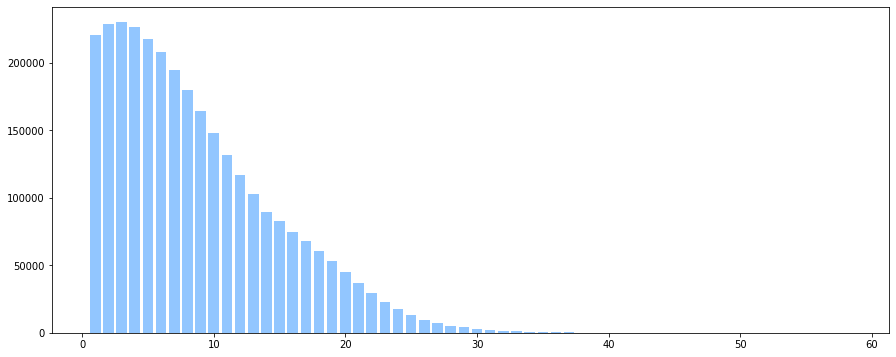

In [8]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(train_len_counter.index.values, train_len_counter.values)

<BarContainer object of 50 artists>

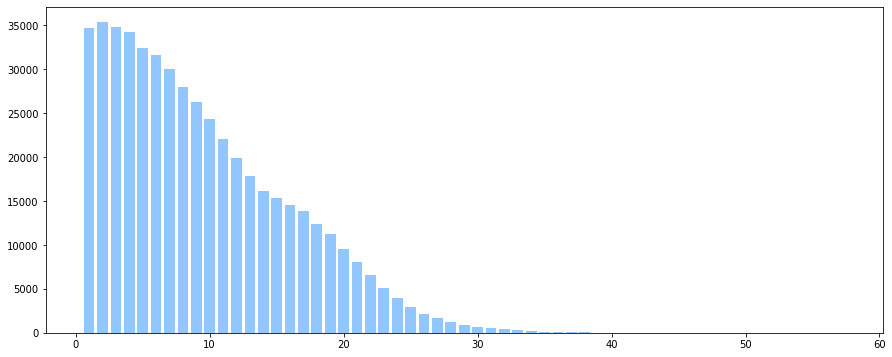

In [9]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(test_len_counter.index.values, test_len_counter.values)

In [10]:
train_lens.max(), test_lens.max()

(58, 57)

* Один из аргументов в функции `dataset_preprocessing_utils.create_padded_buckets` &ndash; `bucket_info` &ndash; словарь, где для конкретной длины последовательности указано до какой длины нужно делать паддинг. Для данного бэйзлайна возьмем простое разбиение на 43 бакета: 
| Длина последовательности | Длина после паддинга |
| :-: | :-: 
| 1 &ndash; 40 | без изменений |
| 41 &ndash; 45 | 45 |
| 46 &ndash; 50 | 50 |
| 51 &ndash; 58 | 58 |

In [11]:
keys_ = list(range(1, 59)) 
lens_ = list(range(1, 41)) + [45] * 5 + [50] * 5 + [58] * 8
bucket_info = dict(zip(keys_, lens_))
bucket_info

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 45,
 42: 45,
 43: 45,
 44: 45,
 45: 45,
 46: 50,
 47: 50,
 48: 50,
 49: 50,
 50: 50,
 51: 58,
 52: 58,
 53: 58,
 54: 58,
 55: 58,
 56: 58,
 57: 58,
 58: 58}

* Так же рассмотрим уникальные значения признаков

In [12]:
for feat, uniq in uniques.items():
    print(f"Feature: {feat}, unique values: {uniq}")

Feature: pre_since_opened, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_since_confirmed, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_pterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_fterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_pclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_fclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
Feature: pre_loans_credit_limit, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_loans_next_pay_summ, unique values: {0, 1, 2, 3, 4, 5, 6, 7}
Feature: pre_loans_outstanding, unique values: {1, 2, 3, 4, 5}
Feature: pre_loans_total_overdue, unique values: {0, 1}
Feature: pre_loans_max_overdue_sum, unique values: {0, 1, 2, 3}
Feature: pre_lo

* Поскольку паддинг будет производиться нулями, а категориальные признаки закодированы, начиная с 0, перед паддингом будем сдвигать все значения на 1.

* Вся описанная выше предобработка данных реализована в виде функции `create_buckets_from_credits`:

In [13]:
def create_buckets_from_credits(path_to_dataset, bucket_info, save_to_path, frame_with_ids = None, 
                                num_parts_to_preprocess_at_once: int = 1, 
                                num_parts_total=50, has_target=False):
    block = 0
    for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Preparing credit data"):
        credits_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, verbose=True)
        credits_frame.loc[:, features] += 1       
        seq = transform_credits_to_sequences(credits_frame)
        print("Transforming credits to sequences is done.")
        
        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on="id")

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = "00" + block_as_str
        else:
            block_as_str = "0" + block_as_str
            
        processed_fragment =  create_padded_buckets(seq, bucket_info=bucket_info, has_target=has_target, 
                                                    save_to_file_path=os.path.join(save_to_path, 
                                                                                   f"processed_chunk_{block_as_str}.pkl"))
        block += 1

* Обучение и валидация будут происходить на семи фолдах.

In [15]:
TRAIN_BUCKETS_PATH_base = "../data/7Folds/train_buckets_fold_num_"
VAL_BUCKETS_PATH_base = "../data/7Folds/val_buckets_fold_num_"
TEST_BUCKETS_PATH = "../data/7Folds/test_buckets_rnn"

np.random.seed(42)

train_target = train_target.sample(frac=1, random_state=42).reset_index(drop=True)

* Подготовим семь пар данных train, val.

In [ ]:
kf = KFold(n_splits=7)

fold_num = 0
for train_index, test_index in kf.split(train_target):
    fold_num = fold_num + 1
    print(fold_num)
    TRAIN_BUCKETS_PATH = TRAIN_BUCKETS_PATH_base + str(fold_num)
    VAL_BUCKETS_PATH = VAL_BUCKETS_PATH_base + str(fold_num)  
    print(TRAIN_BUCKETS_PATH)
    print(VAL_BUCKETS_PATH)
    
    #print("TRAIN:", train_index, "TEST:", test_index)
    train, val = train_target.iloc[train_index], train_target.iloc[test_index]
    
    #print(train.shape, val.shape)

    create_buckets_from_credits(TRAIN_DATA_PATH,
                                bucket_info=bucket_info,
                                save_to_path=TRAIN_BUCKETS_PATH,
                                frame_with_ids=train,
                                num_parts_to_preprocess_at_once=4, 
                                num_parts_total=12, has_target=True)

    dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
    dataset_train

    
    create_buckets_from_credits(TRAIN_DATA_PATH,
                                bucket_info=bucket_info,
                                save_to_path=VAL_BUCKETS_PATH,
                                frame_with_ids=val,
                                num_parts_to_preprocess_at_once=4, 
                                num_parts_total=12, has_target=True)

    dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])
    dataset_val





create_buckets_from_credits(TEST_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TEST_BUCKETS_PATH, num_parts_to_preprocess_at_once=2, 
                            num_parts_total=2)

dataset_test = sorted([os.path.join(TEST_BUCKETS_PATH, x) for x in os.listdir(TEST_BUCKETS_PATH)])
dataset_test

In [16]:
dataset_train = ['../data/7Folds/train_buckets_fold_num_1/processed_chunk_000.pkl',
                 '../data/7Folds/train_buckets_fold_num_1/processed_chunk_001.pkl',
                 '../data/7Folds/train_buckets_fold_num_1/processed_chunk_002.pkl']

dataset_val = ['../data/7Folds/val_buckets_fold_num_1/processed_chunk_000.pkl',
               '../data/7Folds/val_buckets_fold_num_1/processed_chunk_001.pkl',
               '../data/7Folds/val_buckets_fold_num_1/processed_chunk_002.pkl']

dataset_test = ['../data/7Folds/test_buckets_rnn/processed_chunk_000.pkl']


* В папке MOD_DATA_PATH содержаться и данные трейна и данные теста (файлы теста переименнованы в стиле имен трейна).
Эта папка понадобится на этапе псевдолейблинга...

In [18]:
MOD_DATA_PATH = "../data/7Folds/mod_data/"
MOD_TRAIN_TEMPO_BUCKETS_PATH = "../data/7Folds/new_train_tempo"

In [19]:
def get_dataset_mod(train_target_mod):  
    
    create_buckets_from_credits(MOD_DATA_PATH,
                                bucket_info=bucket_info,
                                save_to_path=MOD_TRAIN_TEMPO_BUCKETS_PATH,
                                frame_with_ids=train_target_mod,
                                num_parts_to_preprocess_at_once=2, 
                                num_parts_total=14, has_target=True)

    train_mod = sorted([os.path.join(MOD_TRAIN_TEMPO_BUCKETS_PATH, x) for x in os.listdir(MOD_TRAIN_TEMPO_BUCKETS_PATH)])
    
    return train_mod

### 2. Modeling

In [20]:
from data_generators import batches_generator
from tf_training import train_epoch, eval_model, inference
from training_aux import EarlyStopping

In [21]:
def compute_embed_dim(n_cat: int) -> int:
    return min(600, round(1.6 * n_cat**0.56))

In [22]:
embedding_projections = {feat: (max(uniq)+1, compute_embed_dim(max(uniq)+1)) for feat, uniq in uniques.items()}
embedding_projections

{'pre_since_opened': (20, 9),
 'pre_since_confirmed': (18, 8),
 'pre_pterm': (18, 8),
 'pre_fterm': (17, 8),
 'pre_till_pclose': (17, 8),
 'pre_till_fclose': (16, 8),
 'pre_loans_credit_limit': (20, 9),
 'pre_loans_next_pay_summ': (8, 5),
 'pre_loans_outstanding': (6, 4),
 'pre_loans_total_overdue': (2, 2),
 'pre_loans_max_overdue_sum': (4, 3),
 'pre_loans_credit_cost_rate': (14, 7),
 'pre_loans5': (18, 8),
 'pre_loans530': (20, 9),
 'pre_loans3060': (10, 6),
 'pre_loans6090': (6, 4),
 'pre_loans90': (20, 9),
 'is_zero_loans5': (2, 2),
 'is_zero_loans530': (2, 2),
 'is_zero_loans3060': (2, 2),
 'is_zero_loans6090': (2, 2),
 'is_zero_loans90': (2, 2),
 'pre_util': (20, 9),
 'pre_over2limit': (20, 9),
 'pre_maxover2limit': (20, 9),
 'is_zero_util': (2, 2),
 'is_zero_over2limit': (2, 2),
 'is_zero_maxover2limit': (2, 2),
 'enc_paym_0': (4, 3),
 'enc_paym_1': (4, 3),
 'enc_paym_2': (4, 3),
 'enc_paym_3': (4, 3),
 'enc_paym_4': (4, 3),
 'enc_paym_5': (4, 3),
 'enc_paym_6': (4, 3),
 'enc_pay

In [23]:
def build_transactions_rnn(features, embedding_projections, 
                           rnn_units=128, classifier_units=32, optimizer=None):
    if not optimizer:
        optimizer = keras.optimizers.Adam(lr=1e-3)
        
    inputs = []
    cat_embeds = []
    
    for feature_name in features:
        inp = L.Input(shape=(None, ), dtype="uint32", name=f"input_{feature_name}")
        inputs.append(inp)
        source_size, projection = embedding_projections[feature_name]
        emb = L.Embedding(source_size+1, projection, trainable=True, mask_zero=False, name=f"embedding_{feature_name}")(inp)
        cat_embeds.append(emb)
    
    concated_cat_embeds = L.concatenate(cat_embeds)
    
    
    sequences = L.Bidirectional(L.LSTM(units=rnn_units, return_sequences=True))(concated_cat_embeds)
    
    pooled_avg_sequences = L.GlobalAveragePooling1D()(sequences)
    pooled_max_sequences = L.GlobalMaxPooling1D()(sequences)    
    
    concated = L.concatenate([pooled_avg_sequences, pooled_max_sequences], name='encoder_out')
        
    dense_intermediate = L.Dense(classifier_units, activation="swish")(concated)
    proba = L.Dense(1, activation="sigmoid")(dense_intermediate)
    
    model = Model(inputs=inputs, outputs=proba)
    model.compile(loss="binary_crossentropy", optimizer=optimizer)
    return model

In [24]:
def get_roc_auc_treshold(dataset, preds):
    try:
        preds = val_preds['score'].values
    except:
        pass
    dataset_generator = batches_generator(dataset, batch_size=128, shuffle=False,
                                          output_format="tf", is_train=True)

    dataset_y = []
    for _, y in dataset_generator:
        dataset_y.extend(y)
    dataset_y = np.array(dataset_y)    
        
    print("dataset_y.shape", dataset_y.shape)
    
    fpr, tpr, thresholds = metrics.roc_curve(dataset_y, preds,  drop_intermediate=False)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    scor = roc_auc_score(dataset_y, preds)
    #print('Final split level:',optimal_threshold)    
    #print('Final ROC AUC:    ', scor)
    
    return optimal_threshold, scor, dataset_y

In [25]:
def get_x(model=None, dataset=None, is_train=True):
    dataset_generator = batches_generator(dataset, batch_size=128, shuffle=False,
                                          output_format="tf", is_train=is_train)
    
    X_preds = model.predict(dataset_generator)
    
    return X_preds

In [26]:
def get_y(dataset):
    dataset_generator = batches_generator(dataset, batch_size=128, shuffle=False,
                                          output_format="tf", is_train=True)

    dataset_y = []
    for _, y in dataset_generator:
        dataset_y.extend(y)
    dataset_y = np.array(dataset_y)    
    
    return dataset_y
    

In [27]:
def get_id(dataset):
    dataset_generator = batches_generator(dataset, batch_size=128, shuffle=False,
                                          output_format="tf", is_train=False)

    
    ids=[]
    for _, batch_ids in dataset_generator:
        ids.extend(batch_ids)
    
    ids = np.array(ids)    
      
    
    return ids

In [28]:

def get_lgbm_result(train_enc, train_y, val_enc, val_y, test_enc):
    global cls_model
    
    params = {
        "boosting_type": "gbdt", # gbdt goss
        "objective": "binary",
        "metric": "auc",
        "learning_rate": 0.01,  # 0.003,
        "n_jobs": 8,
        "seed": 15,
        "max_depth": 5,
        "verbose": -1,
    }

   
    
    
    dtrain = lgb.Dataset(
        data=train_enc, label=train_y, free_raw_data=False
    )
    dvalid = lgb.Dataset(
        data=val_enc,  label=val_y, free_raw_data=False
    )

  
    
    
    def lgboost_optimize_params(num_leaves, 
                                feature_fraction, 
                                bagging_fraction,
                                max_depth,
                               ):

        params["num_leaves"] = int(num_leaves)
        params["feature_fraction"] = feature_fraction
        params["bagging_fraction"] = bagging_fraction
        params["max_depth"] = int(max_depth)       
        
        
        

        model = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=50, #1500,
            valid_sets=[dtrain, dvalid],
            categorical_feature="auto",
            early_stopping_rounds=250,
            #verbose_eval=10,
            verbose_eval=False,
        )
       
        
        
        return roc_auc_score(val_y, model.predict(val_enc))

    


    
    params_search={
                    'num_leaves': (24, 45),
                    'feature_fraction': (0.1, 0.8),
                    'bagging_fraction': (0.8, 1),
                    'max_depth': (4, 13),
                   }
    
  
    
    
    
    lgb_params_search = BayesianOptimization(
        lgboost_optimize_params,
        pbounds=params_search,
        random_state=42
    )
    lgb_params_search.maximize(
        init_points=5, n_iter=5 #, acq='ei'
    )                                                    
                                                    
    optimal_lgb_params = lgb_params_search.max                                                

    print(optimal_lgb_params['params'])
    
    
    
    for key in optimal_lgb_params['params']:
        print(key, optimal_lgb_params['params'][key])
        params[key] = optimal_lgb_params['params'][key]
    print()
    
    params['max_depth'] = int((params['max_depth']).round())
    params['num_leaves'] = int((params['num_leaves']).round())
    print('================new params==================')
    print(params)    
    
   
    
    
    
    
    
    
    
    
    cls_model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=7500,  #00,
        valid_sets=[dtrain, dvalid],
        categorical_feature="auto",
        early_stopping_rounds=300,
        verbose_eval=100,
        #verbose_eval=False,
    )

    #ypred_train = cls_model.predict(train_enc)
    ypred_valid = cls_model.predict(val_enc)
    ypred_test = cls_model.predict(test_enc)


    print('roc_auc_score:', roc_auc_score(val_y, ypred_valid))
    print('lgb pass ==========================================')
    print()
    
    return ypred_valid, ypred_test    

In [29]:
def get_df_id_y_from_dataset(dataset):
    ids = []
    generator = batches_generator(dataset, batch_size=128, shuffle=False, 
                                       is_train=False, output_format="tf")
    for _, batch_ids in generator:
        ids.extend(batch_ids)


    y = []
    generator = batches_generator(dataset, batch_size=128, shuffle=False, 
                                       is_train=True, output_format="tf")
    for _, label in generator:
        y.extend(label)


    frame = pd.DataFrame({
            "id": ids,
            "flag": y
        })    

    return frame

In [30]:
def get_extra_train_df_id_y(test_preds, dataset_train, dataset_test, defolt_rate):
    
    percent_to_increase = 0.21
    
    
    idsss = get_id(dataset_test)
    
    test_preds_lgbm_df = pd.DataFrame({"id": idsss, "score": test_preds})
    test_preds_lgbm_df = test_preds_lgbm_df.sort_values('score')
    
    maybe_1_part_size = int(len(test_preds_lgbm_df)*defolt_rate)
    maybe_0_part_size = len(test_preds_lgbm_df) - maybe_1_part_size
    
    
    print(maybe_0_part_size, maybe_1_part_size, len(test_preds_lgbm_df))
    
    
    part_0_to_add_sie = int(maybe_0_part_size * percent_to_increase)
    part_1_to_add_sie = int(maybe_1_part_size * percent_to_increase)
    
    print(part_0_to_add_sie, part_1_to_add_sie)
    
    new_zerro_ids = test_preds_lgbm_df[:part_0_to_add_sie].id.values
    new_ones_ids = test_preds_lgbm_df[-part_1_to_add_sie:].id.values
    
    new_train_0_addition = pd.DataFrame({"id": new_zerro_ids, "flag": np.zeros(len(new_zerro_ids), dtype=np.int)})
    new_train_1_addition = pd.DataFrame({"id": new_ones_ids, "flag": np.ones(len(new_ones_ids), dtype=np.int)})
    raw_train_df         = get_df_id_y_from_dataset(dataset_train)
    
    dfs = [raw_train_df, new_train_0_addition, new_train_1_addition]
    new_train_df = pd.concat( dfs,axis=0, ignore_index=True)
    
    return new_train_df
    

In [31]:
def get_dics_results(models_dic):
    models_list = list(models_dic.keys())
    result_dic ={}
    for n in [4,3,2]:
        for i in combinations(models_list, n):
            result_1 = 1
            result_2 = 0
            name1 = 'mul_'
            name2 = 'sum_'        
            for j in i:
                result_1 = result_1 * models_dic[j]
                result_2 = result_2 + models_dic[j]            
                name1 = name1 + j +'_'
                name2 = name2 + j +'_'    
                
            result_1 = (result_1)**(1/len(i))   
            result_2 = result_2 / len(i)  

            result_dic[name1] = result_1
            result_dic[name2] = result_2


            #print('=====================================')
    z = result_dic.update(models_dic)
    return result_dic


def get_scores(y_valid, result_dic):
    scores_dic ={}
    best = 0.
    for i in result_dic:        
        scor  = roc_auc_score(y_valid, result_dic[i])
        scores_dic[i] = scor
        if scor > best:
            best = scor
            name = i   
        #print(i, result_dic[i])
    #print()    
    #print(name, best)
    return name, scores_dic

In [32]:
num_epochs = 21
train_batch_size = 128
val_batch_szie = 128

### 3. Training

In [33]:
y_val_true_parts  =[] 
y_val_pred_parts  =[] 
y_test_preds      =[] 
scors_list        =[]
cut_list          =[]


y_val_true_parts_net  =[] 
y_val_pred_parts_net  =[] 
y_test_preds_net      =[] 
scors_list_net        =[]
cut_list_net          =[]


y_val_true_parts2  =[] 
y_val_pred_parts2  =[] 
y_test_preds2      =[] 
scors_list2        =[]
cut_list2          =[]


y_val_true_parts_net2  =[] 
y_val_pred_parts_net2  =[] 
y_test_preds_net2      =[] 
scors_list_net2        =[]
cut_list_net2          =[]



y_val_true_parts_final  =[] 
y_val_pred_parts_final  =[] 
y_test_preds_final      =[] 
scors_list_final        =[]
cut_list_final          =[]
















for i in range(1,8):
    
    start = time.time()

    for j in range(3):
        tempo = list(dataset_train[j])
        tempo[38] = str(i)
        dataset_train[j] = ''.join(tempo)
    for j in range(3):        
        tempo = list(dataset_val[j])
        tempo[36] = str(i)
        dataset_val[j] = ''.join(tempo)
        
        
        

    path_to_checkpoints = "./checkpoints/tf_baseline/"
    es = EarlyStopping(patience=3, mode="max", verbose=True, 
                       save_path=os.path.join(path_to_checkpoints, "best_checkpoint__folf_"+str(i)+".pt"), 
                       metric_name="ROC-AUC", save_format="tf")        


    model = build_transactions_rnn(features, embedding_projections)

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}")
        train_epoch(model, dataset_train, batch_size=train_batch_size, 
                    shuffle=True, cur_epoch=epoch, steps_per_epoch=20089)  #21160

        val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_szie)
        es(val_roc_auc, model)

        if es.early_stop:
            print("Early stopping reached. Stop training...")
            break
        train_roc_auc = "Now is not estimated"
        print(f"Epoch {epoch+1} completed. Train ROC AUC: {train_roc_auc}, val ROC AUC: {val_roc_auc}")    





    model.load_weights(os.path.join(path_to_checkpoints, "best_checkpoint__folf_"+str(i)+".pt"))


    depo_path = '../data/depo/'
    model.save_weights(os.path.join(depo_path,  "model_Fold_"+str(i)+"_weights.pt"))

        
        
    
    val_preds  = inference(model, dataset_val,  batch_size=128)
    test_preds = inference(model, dataset_test, batch_size=128)    
    cut_level, val_roc_auc, val_y = get_roc_auc_treshold(dataset_val, val_preds)    
    
    
    y_val_pred_parts_net.append(val_preds['score'].values)     
    y_test_preds_net.append(test_preds['score'].values) 
    y_val_true_parts_net.append(val_y)
    scors_list_net.append(val_roc_auc)
    cut_list_net.append(cut_level)

    y_val_net_st1  = val_preds['score'].values.copy()
    y_test_net_st1 = test_preds['score'].values.copy()
    
    
    print('y_val_net_st1.shape, y_test_net_st1.shape',y_val_net_st1.shape, y_test_net_st1.shape)
    
    
    
    print()
    print('Fold net auc scor :', val_roc_auc)    
    
    depo_path = '../data/depo/'
    with open(os.path.join(depo_path,  "y_val_pred_parts_net_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(y_val_pred_parts_net, f)    
    
    with open(os.path.join(depo_path,  "y_test_preds_net_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(y_test_preds_net, f)    
            
    with open(os.path.join(depo_path,  "y_val_true_parts_net_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(y_val_true_parts_net, f)    
            
    with open(os.path.join(depo_path,  "cut_list_net_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(cut_list_net, f)    
    
    
    
    # На этом этапе получили промежуточные значения после первого обучения сети на текущем фолде
    # и сохранили промежуточные значения
    #==============================================================================================
    

    
    cut_model = Model(inputs=model.input, outputs=model.get_layer('encoder_out').output) 
    
    # модифицировали базовую сеть для дальнейшего получения эмбеддингов данных
    #==============================================================================================
    
    
    
    
    
    X_train_for_lgbm_1 = get_x(model=cut_model, dataset=[dataset_train[0]], is_train=True)
    X_train_for_lgbm_2 = get_x(model=cut_model, dataset=[dataset_train[1]], is_train=True)
    X_train_for_lgbm_3 = get_x(model=cut_model, dataset=[dataset_train[2]], is_train=True)

    X_train_for_lgbm = np.vstack((X_train_for_lgbm_1,X_train_for_lgbm_2, X_train_for_lgbm_3))    
    
    print('X_train_for_lgbm shapes ===> ', X_train_for_lgbm.shape, X_train_for_lgbm_1.shape, X_train_for_lgbm_2.shape, X_train_for_lgbm_3.shape,)
    
    X_val_for_lgbm   = get_x(model=cut_model, dataset=dataset_val, is_train=True)    
    X_test_for_lgbm  = get_x(model=cut_model, dataset=dataset_test, is_train=False)
    
    y_train_for_lgbm = get_y(dataset_train)
    y_val_for_lgbm   = get_y(dataset_val)
    
    
    # получили новый набор данных для использования в бустинге
    #==============================================================================================
    

    
    
    
    val_preds, test_preds = get_lgbm_result(X_train_for_lgbm, 
                                            y_train_for_lgbm, 
                                            X_val_for_lgbm, 
                                            y_val_for_lgbm, 
                                            X_test_for_lgbm)
    

    
    cut_level, val_roc_auc, val_y = get_roc_auc_treshold(dataset_val, val_preds)        
    print('Fold lgbm auc scor:', val_roc_auc) 
    print('Final split level:',cut_level) 
    print()       
        
    print("val_y.shape", val_y.shape)

    
    
    scors_list.append(val_roc_auc)
    cut_list.append(cut_level)
    y_val_true_parts.append(val_y)
    y_val_pred_parts.append(val_preds)    
    y_test_preds.append(test_preds)    
    
    y_val_lstm_st1  = val_preds.copy()
    y_test_lstm_st1 = test_preds.copy()
    print('y_val_lstm_st1.shape, y_test_lstm_st1.shape',y_val_lstm_st1.shape, y_test_lstm_st1.shape)


    depo_path = '../data/depo/'
    with open(os.path.join(depo_path,  "y_val_pred_parts_lgbm_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(y_val_pred_parts, f)    
    
    with open(os.path.join(depo_path,  "y_test_preds_lgbm_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(y_test_preds, f)    
            
    with open(os.path.join(depo_path,  "y_val_true_parts_lgbm_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(y_val_true_parts, f)    
            
    with open(os.path.join(depo_path,  "cut_list_lgbm_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(cut_list, f)    
    
    # На этом этапе получили промежуточные значения после первого обучения бустинга на текущем фолде
    # и сохранили промежуточные значения
    #==============================================================================================
    
    
    
    
    
    
    
    defolt_rate = (y_train_for_lgbm.sum() + y_val_for_lgbm.sum())/(len(y_train_for_lgbm) + len(y_val_for_lgbm))
    train_target_mod = get_extra_train_df_id_y(test_preds, dataset_train, dataset_test, defolt_rate)
    
    # получили новый расширенный train датасет за счет использования псквдолейблинга.

    #==============================================================================================
    #==============================================================================================
    
    
    
    dataset_new_train = get_dataset_mod(train_target_mod)

    path_to_checkpoints = "./checkpoints/tf_baseline/"
    es = EarlyStopping(patience=3, mode="max", verbose=True, 
                       save_path=os.path.join(path_to_checkpoints, "best_checkpoint_st2_folf_"+str(i)+".pt"), 
                       metric_name="ROC-AUC", save_format="tf")        


    model = build_transactions_rnn(features, embedding_projections)

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}")
        train_epoch(model, dataset_new_train, batch_size=train_batch_size, 
                    shuffle=True, cur_epoch=epoch, steps_per_epoch=20089)  #21160 20089

        val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_szie)
        es(val_roc_auc, model)

        if es.early_stop:
            print("Early stopping reached. Stop training...")
            break

        train_roc_auc = "Now is not estimated"
        print(f"Epoch {epoch+1} completed. Train2 ROC AUC: {train_roc_auc}, val ROC AUC: {val_roc_auc}")    





    model.load_weights(os.path.join(path_to_checkpoints, "best_checkpoint_st2_folf_"+str(i)+".pt"))


    depo_path = '../data/depo/'
    model.save_weights(os.path.join(depo_path,  "model_st2_Fold_"+str(i)+"_weights.pt"))








    val_preds  = inference(model, dataset_val,  batch_size=128)
    test_preds = inference(model, dataset_test, batch_size=128)    
    cut_level, val_roc_auc, val_y = get_roc_auc_treshold(dataset_val, val_preds)    


    y_val_pred_parts_net2.append(val_preds['score'].values)     
    y_test_preds_net2.append(test_preds['score'].values) 
    y_val_true_parts_net2.append(val_y)
    scors_list_net2.append(val_roc_auc)
    cut_list_net2.append(cut_level)

    y_val_net_st2  = val_preds['score'].values.copy()
    y_test_net_st2 = test_preds['score'].values.copy()
    
    
    print('y_val_net_st2.shape, y_test_net_st2.shape',y_val_net_st2.shape, y_test_net_st2.shape)

    print()
    print('Fold net2 auc scor :', val_roc_auc)    

    depo_path = '../data/depo/'
    with open(os.path.join(depo_path,  "y_val_pred_parts_net2_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(y_val_pred_parts_net2, f)    

    with open(os.path.join(depo_path,  "y_test_preds_net2_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(y_test_preds_net2, f)    

    with open(os.path.join(depo_path,  "y_val_true_parts_net2_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(y_val_true_parts_net2, f)    

    with open(os.path.join(depo_path,  "cut_list_net2_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(cut_list_net2, f)    

    # На этом этапе получили промежуточные значения после второго обучения сети на текущем фолде
    # и сохранили промежуточные значения
    #==============================================================================================



    cut_model = Model(inputs=model.input, outputs=model.get_layer('encoder_out').output) 

    X_train_for_lgbm_1 = get_x(model=cut_model, dataset=[dataset_new_train[0]], is_train=True)
    X_train_for_lgbm_2 = get_x(model=cut_model, dataset=[dataset_new_train[1]], is_train=True)
    X_train_for_lgbm_3 = get_x(model=cut_model, dataset=[dataset_new_train[2]], is_train=True)

    X_train_for_lgbm_4 = get_x(model=cut_model, dataset=[dataset_new_train[3]], is_train=True)
    X_train_for_lgbm_5 = get_x(model=cut_model, dataset=[dataset_new_train[4]], is_train=True)
    X_train_for_lgbm_6 = get_x(model=cut_model, dataset=[dataset_new_train[5]], is_train=True)
    X_train_for_lgbm_7 = get_x(model=cut_model, dataset=[dataset_new_train[6]], is_train=True)





    X_train_for_lgbm = np.vstack((X_train_for_lgbm_1,X_train_for_lgbm_2, X_train_for_lgbm_3,
                                  X_train_for_lgbm_4,X_train_for_lgbm_5, X_train_for_lgbm_6,
                                  X_train_for_lgbm_7))    

    print('X_train_for_lgbm2 done ')

    X_val_for_lgbm   = get_x(model=cut_model, dataset=dataset_val, is_train=True)    
    X_test_for_lgbm  = get_x(model=cut_model, dataset=dataset_test, is_train=False)

    y_train_for_lgbm = get_y(dataset_new_train)
    y_val_for_lgbm   = get_y(dataset_val)







    val_preds, test_preds = get_lgbm_result(X_train_for_lgbm, 
                                            y_train_for_lgbm, 
                                            X_val_for_lgbm, 
                                            y_val_for_lgbm, 
                                            X_test_for_lgbm)



    cut_level, val_roc_auc, val_y = get_roc_auc_treshold(dataset_val, val_preds)        
    print('Fold lgbm auc scor:', val_roc_auc) 
    print('Final split level:',cut_level) 
    print()       

    print("val_y.shape", val_y.shape)



    scors_list2.append(val_roc_auc)
    cut_list2.append(cut_level)
    y_val_true_parts2.append(val_y)
    y_val_pred_parts2.append(val_preds)    
    y_test_preds2.append(test_preds)    

    y_val_lstm_st2  = val_preds.copy()
    y_test_lstm_st2 = test_preds.copy()
    
    
    print('y_val_lstm_st2.shape, y_test_lstm_st2.shape',y_val_lstm_st2.shape, y_test_lstm_st2.shape)


    depo_path = '../data/depo/'
    with open(os.path.join(depo_path,  "y_val_pred_parts_lgbm2_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(y_val_pred_parts2, f)    

    with open(os.path.join(depo_path,  "y_test_preds_lgbm2_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(y_test_preds2, f)    

    with open(os.path.join(depo_path,  "y_val_true_parts_lgbm2_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(y_val_true_parts2, f)    

    with open(os.path.join(depo_path,  "cut_list_lgbm2_Fold_"+str(i)+".h5"), "wb") as f:
                pickle.dump(cut_list2, f)    




    # На этом этапе получили промежуточные значения после второго обучения бустинга на текущем фолде
    # и сохранили промежуточные значения
    #==============================================================================================


            
            
            
            
            
            
            
            
            
            
 

    models_dic = {'lstm_st1':y_val_lstm_st1, 'lstm_st2':y_val_lstm_st2, 'net_st1':y_val_net_st1, 'net_st2':y_val_net_st2,}
    valid_data_dic = get_dics_results(models_dic)
    
    name, scores_dic = get_scores(val_y, valid_data_dic)
    
    
    print(name,  scores_dic[name])    
    print(scores_dic)    
    print()
    
    models_dic = {'lstm_st1':y_test_lstm_st1, 'lstm_st2':y_test_lstm_st2, 'net_st1':y_test_net_st1, 'net_st2':y_test_net_st2,}
    test_data_dic = get_dics_results(models_dic)


      

    
    fpr, tpr, thresholds = metrics.roc_curve(val_y, valid_data_dic[name], pos_label=1)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_threshold

    
    
    
    
    cut_list_final.append(optimal_threshold)     
    y_val_true_parts_final.append(val_y)
    y_val_pred_parts_final.append(valid_data_dic[name])
    y_test_preds_final.append(test_data_dic[name])         
            
    scors_list_final.append(scores_dic[name])        
            
            
            
    # На этом этапе перебрали все возможные комбинации усреднения среди ранее полученных результатов
    # и выбрали результат с максимальным значением ROCAUC на данном фолде
    # Результат сохранили для последующей обработки.
    #==============================================================================================
            
    



    end = time.time()
    duration = end - start    

    print('Fold:', i , 'pass. Time', duration,  'sec.')    
    print('=======================================================================================================')
    print()
    print()    
    
    #break

3929/3929 [==============================] - 45s 12ms/step
dataset_y.shape (428572,)
y_val_net_st1.shape, y_test_net_st1.shape (428572,) (500000,)

Fold net auc scor : 0.7818612151462768
6717/6717 [==============================] - 69s 10ms/step
X_train_for_lgbm shapes ===>  (2571428, 512) (857198, 512) (857218, 512) (857012, 512)
3929/3929 [==============================] - 40s 10ms/step
|   iter    |  target   | baggin... | featur... | max_depth | num_le... |
-------------------------------------------------------------------------
|  1        |  0.7673   |  0.8749   |  0.7655   |  10.59    |  36.57    |
|  2        |  0.7676   |  0.8312   |  0.2092   |  4.523    |  42.19    |
|  3        |  0.7633   |  0.9202   |  0.5957   |  4.185    |  44.37    |
|  4        |  0.7706   |  0.9665   |  0.2486   |  5.636    |  27.85    |
|  5        |  0.769    |  0.8608   |  0.4673   |  7.888    |  30.12    |
|  6        |  0.77     |  0.9261   |  0.338    |  6.551    |  28.72    |
|  7        |  0

Preparing credit data:   0%|          | 0/7 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_0.pq
../data/7Folds/mod_data/train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_2.pq
../data/7Folds/mod_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_4.pq
../data/7Folds/mod_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_6.pq
../data/7Folds/mod_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_8.pq
../data/7Folds/mod_data/train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_10.pq
../data/7Folds/mod_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_12.pq
../data/7Folds/mod_data/train_data_13.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/39 [00:00<?, ?it/s]

Starting epoch 1
3420/3420 [==============================] - 47s 13ms/step
Validation ROC-AUC improved (-inf --> 0.778439).  Saving model...
Epoch 1 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7784393243078834
Starting epoch 2
Epoch 2/2
3420/3420 [==============================] - 39s 11ms/step
No imporvement in validation ROC-AUC. Current: 0.773890. Current best: 0.778439
EarlyStopping counter: 1 out of 3
Epoch 2 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7738897188548455
Starting epoch 3
Epoch 3/3
3420/3420 [==============================] - 40s 12ms/step
Validation ROC-AUC improved (0.778439 --> 0.782842).  Saving model...
Epoch 3 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7828422524017952
Starting epoch 4
Epoch 4/4
3420/3420 [==============================] - 40s 12ms/step
No imporvement in validation ROC-AUC. Current: 0.779386. Current best: 0.782842
EarlyStopping counter: 1 out of 3
Epoch 4 completed. Train2 ROC AUC: 

Fold: 1 pass. Time 15889.145301580429 sec.


3929/3929 [==============================] - 45s 11ms/step
dataset_y.shape (428572,)
y_val_net_st1.shape, y_test_net_st1.shape (428572,) (500000,)

Fold net auc scor : 0.7852172048423748
6718/6718 [==============================] - 67s 10ms/step
X_train_for_lgbm shapes ===>  (2571428, 512) (857195, 512) (857475, 512) (856758, 512)
3929/3929 [==============================] - 39s 10ms/step
|   iter    |  target   | baggin... | featur... | max_depth | num_le... |
-------------------------------------------------------------------------
|  1        |  0.7706   |  0.8749   |  0.7655   |  10.59    |  36.57    |
|  2        |  0.7713   |  0.8312   |  0.2092   |  4.523    |  42.19    |
|  3        |  0.7676   |  0.9202   |  0.5957   |  4.185    |  44.37    |
|  4        |  0.7734   |  0.9665   |  0.2486   |  5.636    |  27.85    |
|  5        |  0.772    |  0.8608   |  0.4673   |  7.888    |  30.12    |
|  6        |  0.773    |  0.9382   |  0.2901

Preparing credit data:   0%|          | 0/7 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_0.pq
../data/7Folds/mod_data/train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_2.pq
../data/7Folds/mod_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_4.pq
../data/7Folds/mod_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_6.pq
../data/7Folds/mod_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_8.pq
../data/7Folds/mod_data/train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_10.pq
../data/7Folds/mod_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_12.pq
../data/7Folds/mod_data/train_data_13.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/40 [00:00<?, ?it/s]

Starting epoch 1
3425/3425 [==============================] - 49s 14ms/step
Validation ROC-AUC improved (-inf --> 0.779044).  Saving model...
Epoch 1 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7790440708063915
Starting epoch 2
Epoch 2/2
3425/3425 [==============================] - 39s 11ms/step
Validation ROC-AUC improved (0.779044 --> 0.782815).  Saving model...
Epoch 2 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7828146258348063
Starting epoch 3
Epoch 3/3
3425/3425 [==============================] - 39s 11ms/step
Validation ROC-AUC improved (0.782815 --> 0.784102).  Saving model...
Epoch 3 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7841020168005646
Starting epoch 4
Epoch 4/4
3425/3425 [==============================] - 40s 12ms/step
No imporvement in validation ROC-AUC. Current: 0.783822. Current best: 0.784102
EarlyStopping counter: 1 out of 3
Epoch 4 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7838218

Fold: 2 pass. Time 15678.706983327866 sec.


3929/3929 [==============================] - 43s 11ms/step
dataset_y.shape (428572,)
y_val_net_st1.shape, y_test_net_st1.shape (428572,) (500000,)

Fold net auc scor : 0.781169414072427
6719/6719 [==============================] - 66s 10ms/step
X_train_for_lgbm shapes ===>  (2571428, 512) (857306, 512) (856824, 512) (857298, 512)
3929/3929 [==============================] - 38s 10ms/step
|   iter    |  target   | baggin... | featur... | max_depth | num_le... |
-------------------------------------------------------------------------
|  1        |  0.7639   |  0.8749   |  0.7655   |  10.59    |  36.57    |
|  2        |  0.7656   |  0.8312   |  0.2092   |  4.523    |  42.19    |
|  3        |  0.7609   |  0.9202   |  0.5957   |  4.185    |  44.37    |
|  4        |  0.7676   |  0.9665   |  0.2486   |  5.636    |  27.85    |
|  5        |  0.7657   |  0.8608   |  0.4673   |  7.888    |  30.12    |
|  6        |  0.7669   |  0.9382   |  0.2901 

Preparing credit data:   0%|          | 0/7 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_0.pq
../data/7Folds/mod_data/train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_2.pq
../data/7Folds/mod_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_4.pq
../data/7Folds/mod_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_6.pq
../data/7Folds/mod_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_8.pq
../data/7Folds/mod_data/train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_10.pq
../data/7Folds/mod_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_12.pq
../data/7Folds/mod_data/train_data_13.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/38 [00:00<?, ?it/s]

Starting epoch 1
3416/3416 [==============================] - 49s 14ms/step
Validation ROC-AUC improved (-inf --> 0.772133).  Saving model...
Epoch 1 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7721331903535626
Starting epoch 2
Epoch 2/2
3416/3416 [==============================] - 39s 11ms/step
Validation ROC-AUC improved (0.772133 --> 0.779603).  Saving model...
Epoch 2 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7796033616157654
Starting epoch 3
Epoch 3/3
3416/3416 [==============================] - 39s 11ms/step
No imporvement in validation ROC-AUC. Current: 0.779553. Current best: 0.779603
EarlyStopping counter: 1 out of 3
Epoch 3 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7795527544704044
Starting epoch 4
Epoch 4/4
3416/3416 [==============================] - 39s 12ms/step
Validation ROC-AUC improved (0.779603 --> 0.779623).  Saving model...
Epoch 4 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7796228

Fold: 3 pass. Time 16327.919858694077 sec.


3929/3929 [==============================] - 46s 12ms/step
dataset_y.shape (428571,)
y_val_net_st1.shape, y_test_net_st1.shape (428571,) (500000,)

Fold net auc scor : 0.7779516482887016
6719/6719 [==============================] - 66s 10ms/step
X_train_for_lgbm shapes ===>  (2571429, 512) (856983, 512) (857318, 512) (857128, 512)
3929/3929 [==============================] - 39s 10ms/step
|   iter    |  target   | baggin... | featur... | max_depth | num_le... |
-------------------------------------------------------------------------
|  1        |  0.7691   |  0.8749   |  0.7655   |  10.59    |  36.57    |
|  2        |  0.7691   |  0.8312   |  0.2092   |  4.523    |  42.19    |
|  3        |  0.7662   |  0.9202   |  0.5957   |  4.185    |  44.37    |
|  4        |  0.771    |  0.9665   |  0.2486   |  5.636    |  27.85    |
|  5        |  0.7699   |  0.8608   |  0.4673   |  7.888    |  30.12    |
|  6        |  0.7707   |  0.9382   |  0.2901

Preparing credit data:   0%|          | 0/7 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_0.pq
../data/7Folds/mod_data/train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_2.pq
../data/7Folds/mod_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_4.pq
../data/7Folds/mod_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_6.pq
../data/7Folds/mod_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_8.pq
../data/7Folds/mod_data/train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_10.pq
../data/7Folds/mod_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_12.pq
../data/7Folds/mod_data/train_data_13.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/38 [00:00<?, ?it/s]

Starting epoch 1
3418/3418 [==============================] - 48s 14ms/step
Validation ROC-AUC improved (-inf --> 0.773155).  Saving model...
Epoch 1 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7731547450804501
Starting epoch 2
Epoch 2/2
3418/3418 [==============================] - 40s 12ms/step
Validation ROC-AUC improved (0.773155 --> 0.776465).  Saving model...
Epoch 2 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.776464659101878
Starting epoch 3
Epoch 3/3
3418/3418 [==============================] - 50s 15ms/step
Validation ROC-AUC improved (0.776465 --> 0.777511).  Saving model...
Epoch 3 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7775114062814608
Starting epoch 4
Epoch 4/4
3418/3418 [==============================] - 41s 12ms/step
Validation ROC-AUC improved (0.777511 --> 0.781237).  Saving model...
Epoch 4 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7812373472850551
Starting epoch 5
Epoch 5/5
3418/341

Fold: 4 pass. Time 17487.62399506569 sec.


3929/3929 [==============================] - 47s 12ms/step
dataset_y.shape (428571,)
y_val_net_st1.shape, y_test_net_st1.shape (428571,) (500000,)

Fold net auc scor : 0.7821523533979111
6725/6725 [==============================] - 66s 10ms/step
X_train_for_lgbm shapes ===>  (2571429, 512) (856630, 512) (857247, 512) (857552, 512)
3929/3929 [==============================] - 38s 10ms/step
|   iter    |  target   | baggin... | featur... | max_depth | num_le... |
-------------------------------------------------------------------------
|  1        |  0.7672   |  0.8749   |  0.7655   |  10.59    |  36.57    |
|  2        |  0.7678   |  0.8312   |  0.2092   |  4.523    |  42.19    |
|  3        |  0.7639   |  0.9202   |  0.5957   |  4.185    |  44.37    |
|  4        |  0.7703   |  0.9665   |  0.2486   |  5.636    |  27.85    |
|  5        |  0.769    |  0.8608   |  0.4673   |  7.888    |  30.12    |
|  6        |  0.7701   |  0.9382   |  0.2901 

Preparing credit data:   0%|          | 0/7 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_0.pq
../data/7Folds/mod_data/train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_2.pq
../data/7Folds/mod_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_4.pq
../data/7Folds/mod_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_6.pq
../data/7Folds/mod_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_8.pq
../data/7Folds/mod_data/train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_10.pq
../data/7Folds/mod_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_12.pq
../data/7Folds/mod_data/train_data_13.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/39 [00:00<?, ?it/s]

Starting epoch 1
3422/3422 [==============================] - 47s 14ms/step
Validation ROC-AUC improved (-inf --> 0.773853).  Saving model...
Epoch 1 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7738526651992567
Starting epoch 2
Epoch 2/2
3422/3422 [==============================] - 40s 12ms/step
Validation ROC-AUC improved (0.773853 --> 0.778507).  Saving model...
Epoch 2 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7785073395636172
Starting epoch 3
Epoch 3/3
3422/3422 [==============================] - 41s 12ms/step
Validation ROC-AUC improved (0.778507 --> 0.779391).  Saving model...
Epoch 3 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.779390617019982
Starting epoch 4
Epoch 4/4
3422/3422 [==============================] - 40s 12ms/step
Validation ROC-AUC improved (0.779391 --> 0.781865).  Saving model...
Epoch 4 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7818646706450582
Starting epoch 5
Epoch 5/5
3422/342

Fold: 5 pass. Time 16226.168600320816 sec.


3929/3929 [==============================] - 46s 12ms/step
dataset_y.shape (428571,)
y_val_net_st1.shape, y_test_net_st1.shape (428571,) (500000,)

Fold net auc scor : 0.7818442318958214
6714/6714 [==============================] - 68s 10ms/step
X_train_for_lgbm shapes ===>  (2571429, 512) (857432, 512) (857227, 512) (856770, 512)
3929/3929 [==============================] - 40s 10ms/step
|   iter    |  target   | baggin... | featur... | max_depth | num_le... |
-------------------------------------------------------------------------
|  1        |  0.7655   |  0.8749   |  0.7655   |  10.59    |  36.57    |
|  2        |  0.7687   |  0.8312   |  0.2092   |  4.523    |  42.19    |
|  3        |  0.7634   |  0.9202   |  0.5957   |  4.185    |  44.37    |
|  4        |  0.7713   |  0.9665   |  0.2486   |  5.636    |  27.85    |
|  5        |  0.7693   |  0.8608   |  0.4673   |  7.888    |  30.12    |
|  6        |  0.7711   |  0.9382   |  0.2901

Preparing credit data:   0%|          | 0/7 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_0.pq
../data/7Folds/mod_data/train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_2.pq
../data/7Folds/mod_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_4.pq
../data/7Folds/mod_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_6.pq
../data/7Folds/mod_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_8.pq
../data/7Folds/mod_data/train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_10.pq
../data/7Folds/mod_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_12.pq
../data/7Folds/mod_data/train_data_13.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/40 [00:00<?, ?it/s]

Starting epoch 1
3418/3418 [==============================] - 47s 13ms/step
Validation ROC-AUC improved (-inf --> 0.764592).  Saving model...
Epoch 1 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7645923335868678
Starting epoch 2
Epoch 2/2
3418/3418 [==============================] - 39s 11ms/step
Validation ROC-AUC improved (0.764592 --> 0.777960).  Saving model...
Epoch 2 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7779603536333808
Starting epoch 3
Epoch 3/3
3418/3418 [==============================] - 39s 12ms/step
Validation ROC-AUC improved (0.777960 --> 0.778016).  Saving model...
Epoch 3 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7780160414839676
Starting epoch 4
Epoch 4/4
3418/3418 [==============================] - 39s 11ms/step
Validation ROC-AUC improved (0.778016 --> 0.782619).  Saving model...
Epoch 4 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7826191564762364
Starting epoch 5
Epoch 5/5
3418/34

Fold: 6 pass. Time 17798.172694206238 sec.


3929/3929 [==============================] - 46s 12ms/step
dataset_y.shape (428571,)
y_val_net_st1.shape, y_test_net_st1.shape (428571,) (500000,)

Fold net auc scor : 0.7826120792708716
6719/6719 [==============================] - 66s 10ms/step
X_train_for_lgbm shapes ===>  (2571429, 512) (857256, 512) (856691, 512) (857482, 512)
3929/3929 [==============================] - 39s 10ms/step
|   iter    |  target   | baggin... | featur... | max_depth | num_le... |
-------------------------------------------------------------------------
|  1        |  0.7669   |  0.8749   |  0.7655   |  10.59    |  36.57    |
|  2        |  0.7664   |  0.8312   |  0.2092   |  4.523    |  42.19    |
|  3        |  0.7629   |  0.9202   |  0.5957   |  4.185    |  44.37    |
|  4        |  0.7693   |  0.9665   |  0.2486   |  5.636    |  27.85    |
|  5        |  0.7685   |  0.8608   |  0.4673   |  7.888    |  30.12    |
|  6        |  0.7696   |  0.9733   |  0.2293

Preparing credit data:   0%|          | 0/7 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_0.pq
../data/7Folds/mod_data/train_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_2.pq
../data/7Folds/mod_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_4.pq
../data/7Folds/mod_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_6.pq
../data/7Folds/mod_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_8.pq
../data/7Folds/mod_data/train_data_9.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_10.pq
../data/7Folds/mod_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
../data/7Folds/mod_data/train_data_12.pq
../data/7Folds/mod_data/train_data_13.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/38 [00:00<?, ?it/s]

Starting epoch 1
3417/3417 [==============================] - 48s 14ms/step
Validation ROC-AUC improved (-inf --> 0.773308).  Saving model...
Epoch 1 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7733080500430407
Starting epoch 2
Epoch 2/2
3417/3417 [==============================] - 40s 12ms/step
Validation ROC-AUC improved (0.773308 --> 0.774472).  Saving model...
Epoch 2 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7744719121915995
Starting epoch 3
Epoch 3/3
3417/3417 [==============================] - 40s 12ms/step
Validation ROC-AUC improved (0.774472 --> 0.778180).  Saving model...
Epoch 3 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7781800848709752
Starting epoch 4
Epoch 4/4
3417/3417 [==============================] - 40s 12ms/step
No imporvement in validation ROC-AUC. Current: 0.773953. Current best: 0.778180
EarlyStopping counter: 1 out of 3
Epoch 4 completed. Train2 ROC AUC: Now is not estimated, val ROC AUC: 0.7739533

Fold: 7 pass. Time 17090.164115667343 sec.




* СОбираем данные ранее обученных фолдов в единое целое. Смотрим на значения на валидации и готовим сабмит...

In [4]:
def get_summary(cut_list, y_val_pred_list, y_test_preds_list, y_val_true_list, dataset_test):
    
    
    y_val_pred_parts, y_test_preds, y_val_true_parts = y_val_pred_list.copy(), y_test_preds_list.copy(), y_val_true_list.copy()
    
    
    

    k_list=[]
    for i in range(len(cut_list)):
        k = 0.5/cut_list[i]
        k_list.append(k)

    print(k_list)



    for i in range(len(y_val_pred_parts)):
        y_val_pred_parts[i] = y_val_pred_parts[i]*k_list[i]

    for i in range(len(y_test_preds)):
        y_test_preds[i] = y_test_preds[i]*k_list[i]



    y_end  =y_test_preds[0]
    y      =y_val_true_parts[0].reshape(-1,1)
    y_vpred=y_val_pred_parts[0].reshape(-1,1)


    for i in range(1,len(y_val_true_parts)):
        y_val_true_parts[i]=y_val_true_parts[i].reshape(-1,1)
        y_val_pred_parts[i]=y_val_pred_parts[i].reshape(-1,1)  
        y=np.vstack((y,y_val_true_parts[i]))
        y_vpred=np.vstack((y_vpred,y_val_pred_parts[i]))  



    for i in range(1,len(y_test_preds)):
        y_end         = y_end*y_test_preds[i]
    y_end      = y_end**(1/len(y_test_preds))



    test_generator = batches_generator(dataset_test, batch_size=128, shuffle=False,
                                       is_train=False, output_format="tf")


    ids=[]
    for _, batch_ids in test_generator:
        ids.extend(batch_ids)

    test_preds = pd.DataFrame({"id": ids, "score": y_end})
    
    print('Final ROC AUC:    ', roc_auc_score(y, y_vpred))
    
    return test_preds

In [36]:
test_preds = get_summary(cut_list_final, y_val_pred_parts_final, y_test_preds_final, y_val_true_parts_final, dataset_test)
test_preds.to_csv('./result_zero_bidirect_final.csv', index=False)
test_preds

[15.264348829148735, 12.938998017323682, 14.765930223398506, 13.885978417775728, 15.483432943345685, 14.76926081337089, 13.841803344553167]
Final ROC AUC:     0.7877423734748454


,id,score
0,3000014,0.320613
1,3000020,2.383898
2,3000027,0.535466
3,3000043,1.177290
4,3000049,0.337915
...,...,...
499995,3286660,0.282860
499996,3345810,0.406660
499997,3434512,0.502408
499998,3000786,0.316670


In [37]:
test_preds = get_summary(cut_list, y_val_pred_parts, y_test_preds, y_val_true_parts, dataset_test)
test_preds.to_csv('./result_zero_bidirect_lgbm_st1.csv', index=False)
test_preds

[14.994380260631106, 13.804035801628771, 15.672635489057242, 13.50920895701096, 13.059560011561661, 15.326034942573466, 16.28934079767007]
Final ROC AUC:     0.7855718102838845


,id,score
0,3000014,0.330813
1,3000020,2.147201
2,3000027,0.556547
3,3000043,1.135493
4,3000049,0.329853
...,...,...
499995,3286660,0.285625
499996,3345810,0.399618
499997,3434512,0.517880
499998,3000786,0.322417


In [38]:
test_preds = get_summary(cut_list_net, y_val_pred_parts_net, y_test_preds_net, y_val_true_parts_net, dataset_test)
test_preds.to_csv('./result_zero_bidirect_lgbm_st1_net.csv', index=False)
test_preds

[14.64503924450308, 14.546089515345399, 10.716060702377733, 15.14457753563696, 14.441804685864987, 13.591012160729047, 11.998284346810102]
Final ROC AUC:     0.781553226269528


,id,score
0,3000014,0.281635
1,3000020,2.093080
2,3000027,0.497502
3,3000043,1.187533
4,3000049,0.377939
...,...,...
499995,3286660,0.193536
499996,3345810,0.217430
499997,3434512,0.209293
499998,3000786,0.179868


In [39]:
test_preds = get_summary(cut_list2, y_val_pred_parts2, y_test_preds2, y_val_true_parts2, dataset_test)
test_preds.to_csv('./result_zero_bidirect_lgbm_st2.csv', index=False)
test_preds

[14.785501707138963, 13.968257536639149, 16.38301973249971, 14.707461629631956, 15.110536811510057, 14.97431151350499, 14.792343714638763]
Final ROC AUC:     0.7851486741151767


,id,score
0,3000014,0.330930
1,3000020,2.780350
2,3000027,0.527159
3,3000043,1.244168
4,3000049,0.362379
...,...,...
499995,3286660,0.299961
499996,3345810,0.433428
499997,3434512,0.514871
499998,3000786,0.324264


In [40]:
test_preds = get_summary(cut_list_net2, y_val_pred_parts_net2, y_test_preds_net2, y_val_true_parts_net2, dataset_test)
test_preds.to_csv('./result_zero_bidirect_lgbm_st2_net.csv', index=False)
test_preds

[15.347553063273423, 15.744064878563252, 11.034456087555641, 17.818325147323616, 13.479846675447162, 14.794938374323788, 11.474333928945297]
Final ROC AUC:     0.7816066897256106


,id,score
0,3000014,0.288091
1,3000020,2.018573
2,3000027,0.360361
3,3000043,1.490736
4,3000049,0.373507
...,...,...
499995,3286660,0.200067
499996,3345810,0.266556
499997,3434512,0.317302
499998,3000786,0.260035


In [41]:
np.array(scors_list).mean()

0.7860067234624296

In [42]:
np.array(scors_list2).mean()

0.785318248346951

In [43]:
np.array(scors_list_net).mean()

0.7818297352734834

In [44]:
np.array(scors_list_net2).mean()

0.7819407194238196

In [45]:
np.array(scors_list_final).mean()

0.7880998830601434